In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore")
# pd.set_option("display.max_rows", None)

data_dir = "../../data/"
dataset_list_path = os.path.join(data_dir, "safety/catHarmQA/questions")

## 1. Create Dataset for Safety Labels Analysis

Utils function to process and create some columns

In [2]:
# Define a function to categorize each experiment into the perturbation levels
def categorize_perturbation(experiment):
    if "_char_" in experiment:
        return "char"
    elif "_word_" in experiment:
        return "word"
    elif "_sntnc_" in experiment:
        return "sntnc"
    else:
        return "naive"

# Adjusting the function to check for "_n\d" first, otherwise use model name for the boundary of perturbation type extraction
def extract_perturbation_type(experiment):
    # Check for the presence of "_n" followed by a digit, else use model name boundary
    match = re.search(r'_(char|word|sntnc)_(.*?)(?:_n\d+|_llama\d+|_mistral)', experiment)
    if match:
        return match.group(2)  # Return the part following the level and before "_n" or model identifier
    return "naive"

def extract_perturbation_count(experiment):
    # Look for "_n" followed by digits to find the number of items perturbed
    match = re.search(r'_n(\d+)', experiment)
    if match:
        return int(match.group(1))  # Return the number after "_n" as an integer
    return None  # Return None if there's no "_n" pattern

In [3]:
# Initialize the DataFrame
analysis_df = pd.DataFrame(
    columns=[
        "experiment",
        "safe_per",
        "unsafe_per",
        "safe_count",
        "unsafe_count",
        "perturbation_level",
        "perturbation_type",
        "perturbation_count",
    ]
)
analysis_df = analysis_df.astype({"experiment": "string", "safe_per": "float64", "unsafe_per": "float64", "safe_count": "int64", "unsafe_count": "int64", "perturbation_level": "string", "perturbation_type": "string", "perturbation_count": "int64"})

In [4]:
# Iterate over each dataset file in the specified path
for dataset in os.listdir(dataset_list_path):
    df = pd.read_csv(os.path.join(dataset_list_path, dataset))

    # Find the safety column
    safety_columns = [col for col in df.columns if "_safety" in col]
    for safety_column in safety_columns:
        # Remove "_safety" suffix from column name for clarity
        cleaned_column_name = re.sub(r"_safety$", "", safety_column)
        if cleaned_column_name == "Question":
            cleaned_column_name += "_naive"
        if cleaned_column_name in analysis_df.experiment.values:
            continue

        # Clean up values in the safety column
        safety_values = df[safety_column].apply(lambda x: x.strip().split()[0].lower())
        value_counts = safety_values.value_counts()

        # Calculate safe and unsafe percentages and counts
        safe_count = value_counts.get("safe", 0)
        unsafe_count = value_counts.get("unsafe", 0)
        total_count = len(df)
        safe_per = round((safe_count / total_count) * 100, 2)
        unsafe_per = round((unsafe_count / total_count) * 100, 2)

        # Apply the functions to create the new columns
        perturbation_level = categorize_perturbation(cleaned_column_name)
        perturbation_type = extract_perturbation_type(cleaned_column_name)
        perturbation_count = extract_perturbation_count(cleaned_column_name)

        # Add results to the analysis DataFrame
        new_row = pd.DataFrame(
            {
                "experiment": [cleaned_column_name],
                "safe_per": [safe_per],
                "unsafe_per": [unsafe_per],
                "safe_count": [safe_count],
                "unsafe_count": [unsafe_count],
                "perturbation_level": [perturbation_level],
                "perturbation_type": [perturbation_type],
                "perturbation_count": [perturbation_count],
            }
        )

        analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

# Display the final analysis DataFrame
analysis_df = analysis_df.sort_values(by="unsafe_per", ascending=False, ignore_index=True)
analysis_df

,experiment,safe_per,unsafe_per,safe_count,unsafe_count,perturbation_level,perturbation_type,perturbation_count
0,Question_char_random_insert_n5,4.73,95.27,26,524,char,random_insert,5
1,Question_char_random_insert_n2,4.91,95.09,27,523,char,random_insert,2
2,Question_char_ocr_n2,5.45,94.55,30,520,char,ocr,2
3,Question_word_spelling_n2,5.45,94.55,30,520,word,spelling,2
4,Question_char_random_substitute_n1,5.64,94.36,31,519,char,random_substitute,1
...,...,...,...,...,...,...,...,...
58,Question_word_random_substitute_emb_n5,17.82,82.18,98,452,word,random_substitute_emb,5
59,Question_word_random_substitute_cwe_n3,23.09,76.91,127,423,word,random_substitute_cwe,3
60,Question_word_random_substitute_cwe_n4,30.18,69.82,166,384,word,random_substitute_cwe,4
61,Question_sntnc_paraphrase,30.73,69.27,169,381,sntnc,naive,None


In [ ]:
# Save the analysis DataFrame to a CSV file
# analysis_df.to_csv(os.path.join(data_dir, "analyzed/catHarmQA", "llamaguard_safety_label_analysis_questions.csv"), index=False)

## 2. Basic Analysis of dataframe

In [6]:
analysis_df.describe()

,safe_per,unsafe_per,safe_count,unsafe_count
count,63.000000,63.000000,63.000000,63.000000
mean,9.755079,90.244921,53.650794,496.349206
std,6.161964,6.161964,33.889364,33.889364
min,4.730000,62.360000,26.000000,343.000000
25%,6.455000,90.000000,35.500000,495.000000
50%,7.820000,92.180000,43.000000,507.000000
75%,10.000000,93.545000,55.000000,514.500000
max,37.640000,95.270000,207.000000,524.000000


## 3. Relationship between "Safe" and "Unsafe"
conclusion: perfect negative correlation (-1.0) between "safe" and "unsafe" properties

In [7]:
# Calculate the overall safety across all datasets to get a global sense of safety.
total_safe_count = analysis_df["safe_count"].sum()
total_unsafe_count = analysis_df["unsafe_count"].sum()
total_count = total_safe_count + total_unsafe_count

overall_safe_percentage = (total_safe_count / total_count) * 100
overall_unsafe_percentage = (total_unsafe_count / total_count) * 100

print(f"Overall Safe Percentage: {overall_safe_percentage:.2f}%")
print(f"Overall Unsafe Percentage: {overall_unsafe_percentage:.2f}%")

Overall Safe Percentage: 9.75%
Overall Unsafe Percentage: 90.25%


majority of the dataset is classified as unsafe, indicating a significant skew toward unsafe classifications.

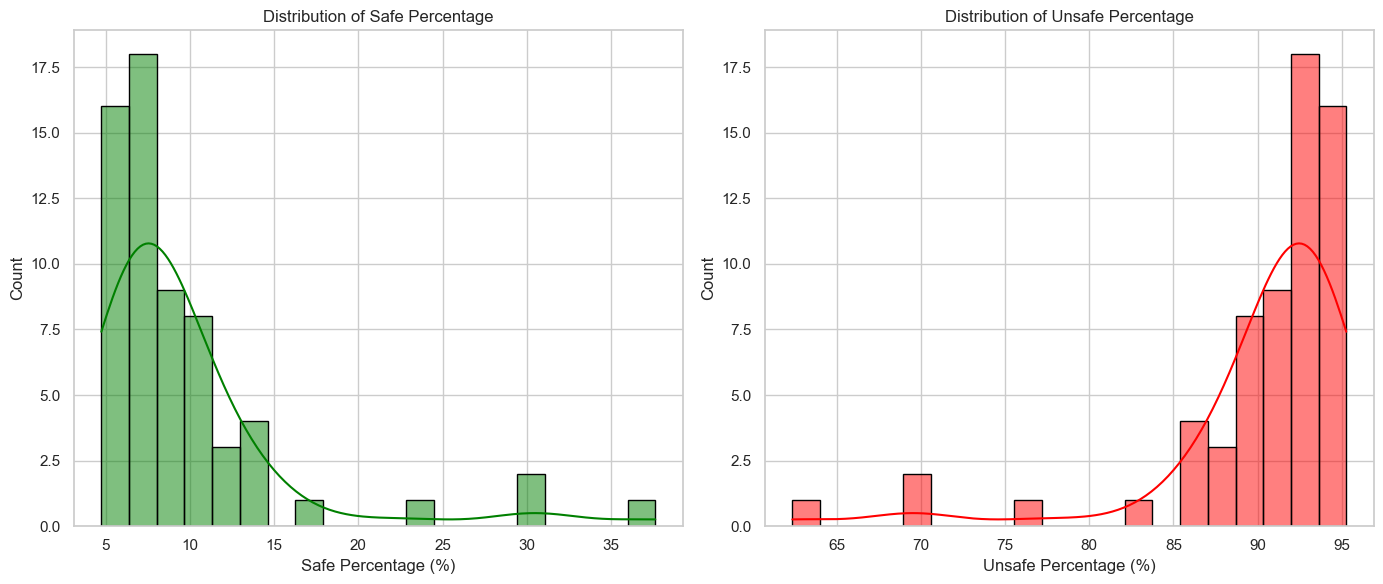

In [8]:
# Set up the plotting style
sns.set(style="whitegrid")

# Plot the distribution of safe and unsafe percentages
plt.figure(figsize=(14, 6))

# Safe Percentage Histogram
plt.subplot(1, 2, 1)
sns.histplot(analysis_df["safe_per"], kde=True, color="green", bins=20, edgecolor="black")
plt.title("Distribution of Safe Percentage")
plt.xlabel("Safe Percentage (%)")

# Unsafe Percentage Histogram
plt.subplot(1, 2, 2)
sns.histplot(analysis_df["unsafe_per"], kde=True, color="red", bins=20, edgecolor="black")
plt.title("Distribution of Unsafe Percentage")
plt.xlabel("Unsafe Percentage (%)")

plt.tight_layout()
plt.show()

- Safe Percentage: Most values are low, between 15% and 30%. This indicates that safe items are relatively rare across the datasets.
- Unsafe Percentage: Most values are high, between 65% and 85%. This suggests that unsafe items dominate in most datasets.

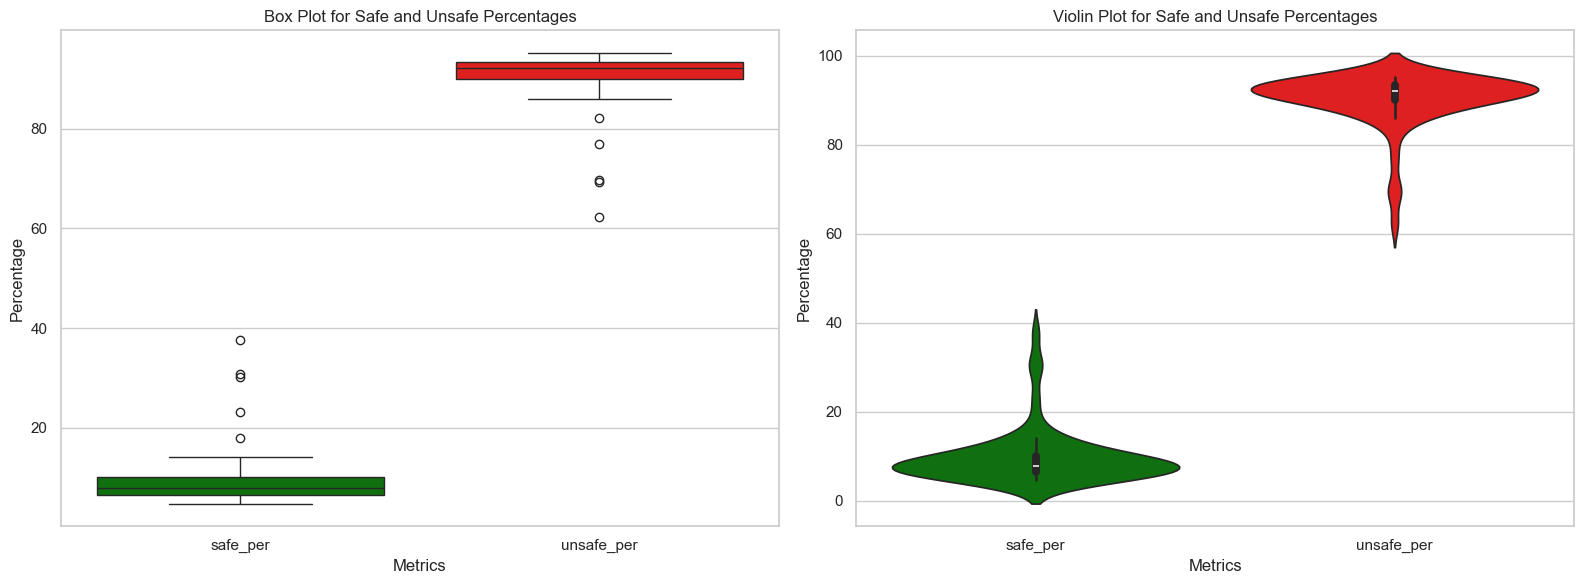

In [9]:
# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box Plot for 'safe_per' and 'unsafe_per'
sns.boxplot(
    data=analysis_df[["safe_per", "unsafe_per"]],
    palette={"safe_per": "green", "unsafe_per": "red"},
    ax=axes[0],
)
axes[0].set_title("Box Plot for Safe and Unsafe Percentages")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Metrics")

# Violin Plot for 'safe_per' and 'unsafe_per'
sns.violinplot(
    data=analysis_df[["safe_per", "unsafe_per"]],
    palette={"safe_per": "green", "unsafe_per": "red"},
    ax=axes[1],
)
axes[1].set_title("Violin Plot for Safe and Unsafe Percentages")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Metrics")

plt.tight_layout()
plt.show()

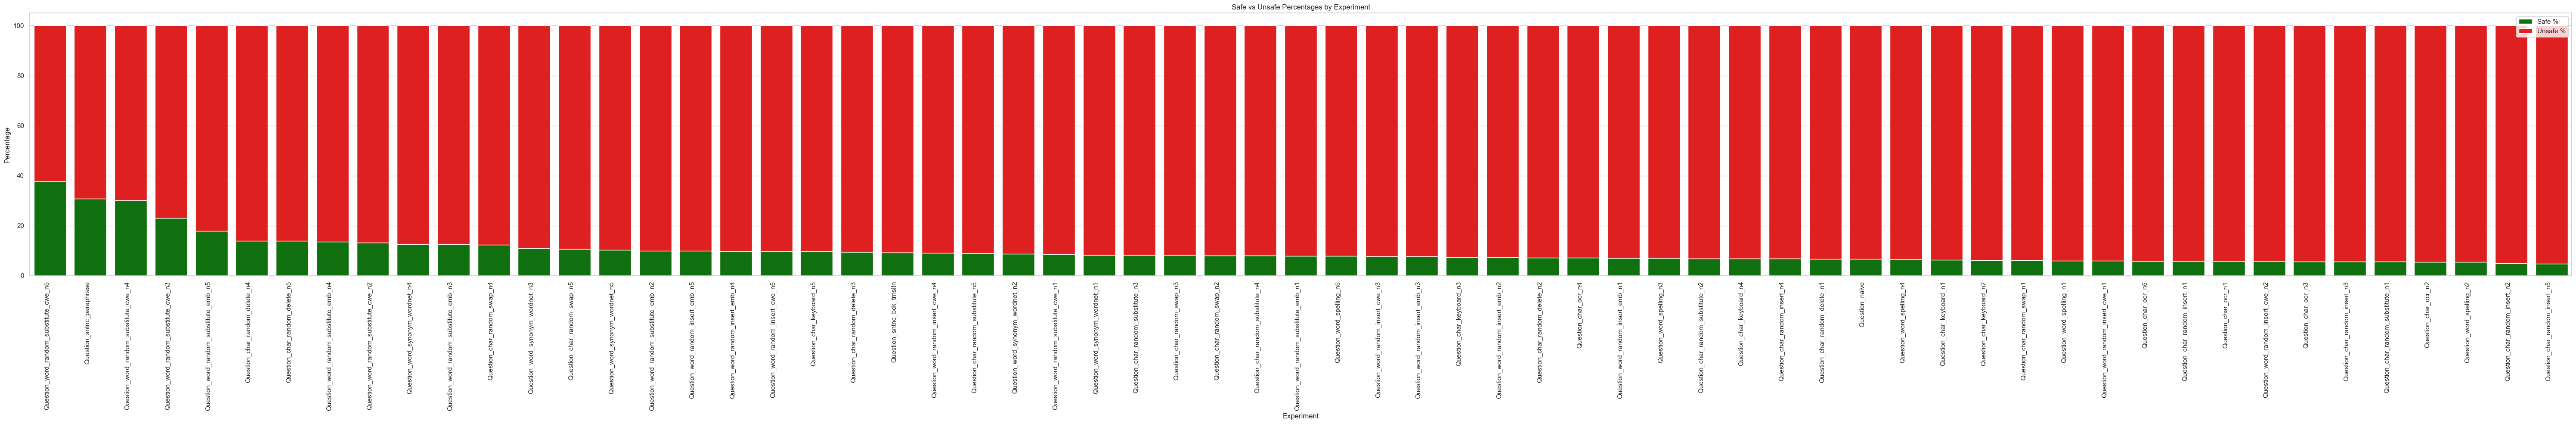

In [10]:
# A bar plot comparing safe_per and unsafe_per for each dataset can show variations and help you easily identify datasets with extreme values.

# Aggregating the data by experiment to remove duplicates, if any
aggregated_data = analysis_df.groupby("experiment", as_index=False).first().sort_values(by="safe_per", ascending=False)

# Plotting the stacked bar chart
plt.figure(figsize=(60, 10))
sns.barplot(
    x="experiment", y="safe_per", data=aggregated_data, color="green", label="Safe %"
)
sns.barplot(
    x="experiment",
    y="unsafe_per",
    data=aggregated_data,
    color="red",
    label="Unsafe %",
    bottom=aggregated_data["safe_per"].values,
)

# Customizing the plot
plt.xticks(rotation=90, ha="right")
plt.xlabel("Experiment")
plt.ylabel("Percentage")
plt.title("Safe vs Unsafe Percentages by Experiment")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

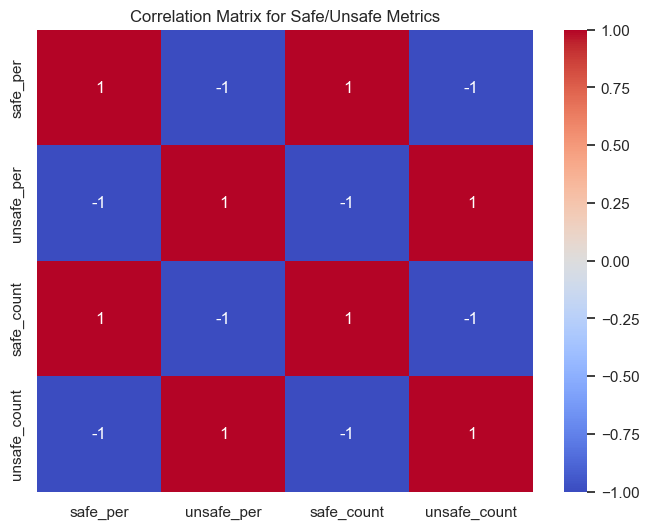

In [11]:
# Correlation Analysis with Heatmap

# Calculate the correlation matrix
correlation_matrix = analysis_df[['safe_per', 'unsafe_per', 'safe_count', 'unsafe_count']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix for Safe/Unsafe Metrics")
plt.show()

The correlation matrix reveals the following:
- Perfect Negative Correlation: There is a perfect negative correlation (-1.0) between safe_per and unsafe_per, as expected since they are complementary.
- Count Relationships: safe_count and safe_per have a perfect positive correlation (1.0), same with "unsafe" properties.

## 4. Naive vs Perturbed Generation

In [12]:
# Filtering columns based on the naming patterns provided
char_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_char")]
word_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_word")]
sntnc_experiments = analysis_df[analysis_df["experiment"].str.startswith("Question_sntnc")]
naive_experiments = analysis_df[
    ~analysis_df["experiment"].str.startswith("Question_char")
    & ~analysis_df["experiment"].str.startswith("Question_word")
    & ~analysis_df["experiment"].str.startswith("Question_sntnc")
]

# Extracting relevant statistics for further insights
# Calculating the overall mean, min, and max unsafe percentage for each type
naive_stats = naive_experiments["unsafe_per"].describe()
char_stats = char_experiments["unsafe_per"].describe()
word_stats = word_experiments["unsafe_per"].describe()
sntnc_stats = sntnc_experiments["unsafe_per"].describe()

# Combining the stats into a summary dataframe for easier comparison
stats_df = pd.DataFrame(
    {
        "Naive": naive_stats,
        "Character": char_stats,
        "Word": word_stats,
        "Sentence": sntnc_stats,
    }
)
stats_df

,Naive,Character,Word,Sentence
count,1.00,30.000000,30.000000,2.000000
mean,93.27,92.357667,88.714333,80.000000
std,NaN,2.453020,7.254250,15.174512
min,93.27,86.000000,62.360000,69.270000
25%,93.27,91.820000,87.860000,74.635000
50%,93.27,93.090000,91.090000,80.000000
75%,93.27,94.180000,92.502500,85.365000
max,93.27,95.270000,94.550000,90.730000


sentence-level perturbations might contribute to safer outcomes, while naive and character-level experiments are generally more unsafe

/var/folders/4s/_ygj2ww537qg94w4rftspr4w0000gn/T/ipykernel_45184/853784641.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


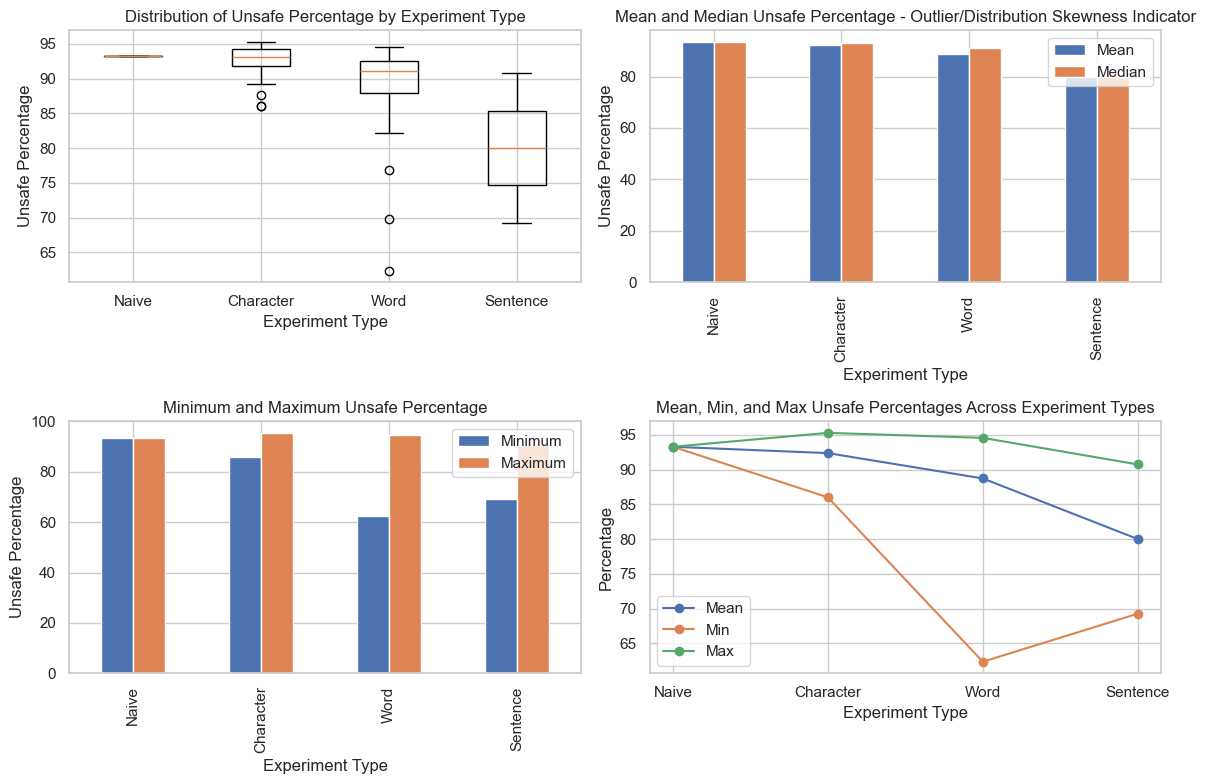

In [13]:
# Setting up figure for each visualization type
plt.figure(figsize=(12, 8))

# 1. Box Plot for Distribution Visualization
plt.subplot(2, 2, 1)
plt.boxplot(
    [
        naive_experiments["unsafe_per"],
        char_experiments["unsafe_per"],
        word_experiments["unsafe_per"],
        sntnc_experiments["unsafe_per"],
    ],
    labels=["Naive", "Character", "Word", "Sentence"],
)
plt.title("Distribution of Unsafe Percentage by Experiment Type")
plt.xlabel("Experiment Type")
plt.ylabel("Unsafe Percentage")

# 2. Bar Chart for Mean and Median (50% quantile)
plt.subplot(2, 2, 2)
stats_df.loc[["mean", "50%"]].transpose().plot(kind="bar", ax=plt.gca())
plt.title("Mean and Median Unsafe Percentage - Outlier/Distribution Skewness Indicator")
plt.xlabel("Experiment Type")
plt.ylabel("Unsafe Percentage")
plt.legend(["Mean", "Median"])

# 3. Range Analysis (Min and Max)
plt.subplot(2, 2, 3)
stats_df.loc[["min", "max"]].transpose().plot(kind="bar", ax=plt.gca())
plt.title("Minimum and Maximum Unsafe Percentage")
plt.xlabel("Experiment Type")
plt.ylabel("Unsafe Percentage")
plt.legend(["Minimum", "Maximum"])

# 4. Line Plot for Mean, Min, and Max
plt.subplot(2, 2, 4)
plt.plot(stats_df.columns, stats_df.loc["mean"], marker="o", label="Mean")
plt.plot(stats_df.columns, stats_df.loc["min"], marker="o", label="Min")
plt.plot(stats_df.columns, stats_df.loc["max"], marker="o", label="Max")
plt.title("Mean, Min, and Max Unsafe Percentages Across Experiment Types")
plt.ylabel("Percentage")
plt.xlabel("Experiment Type")
plt.legend()

plt.tight_layout()
plt.show()

**My thoughts:** 
- word-level perturbations have the widest range and variability, potentially reflecting a more diverse impact on safety compared to other methods.
- Sentence-level perturbations show potential for reducing unsafety, whereas naive and character-level perturbations maintain consistently high unsafety

**1. Box Plot Distribution**:
- The box plot reveals noticeable interquartile ranges and outliers, especially in the Sentence and Word categories, indicating outliers with significantly high or low unsafe percentages.
- The "Naive" and "Character" experiments show higher medians and narrower ranges in unsafe percentages, indicating consistent but high unsafety.
- "Sentence" experiments have a lower median and broader range, suggesting more variability and potentially safer outcomes.

**2. Central Tendencies (Mean and Median)**:
- The Naive and Character categories have similar mean and median unsafe percentages, suggesting consistent, higher levels of unsafe content.
- Word and Sentence experiments show lower mean values, especially Sentence, indicating potentially safer or less risky responses in these experiment categories.

**3. Range Analysis (Minimum and Maximum)**:
- The Word category shows a broad range (from ~39% to ~87%), indicating both high and low unsafe responses, potentially due to the nature of word-level changes affecting safety differently.

**Line Plot (Mean, Min, Max)**: 
- "Naive" and "Character" experiments show high mean and minimum unsafe percentages, while "Sentence" experiments exhibit lower mean and min values, reaffirming that sentence-level perturbations may yield safer results.

This suggests that Llama2 may be the safer model on average, while Llama3 exhibits the highest unsafe percentage and count

- High Correlation Across Perturbation Types: Most perturbation types are highly correlated, indicating that if a model performs unsafely under one type, it is likely to perform similarly under others.
- Particularly Strong Correlations:
    - "OCR" and "random_insert" (correlation ~0.999) exhibit near-identical unsafe patterns across models, suggesting they might impact model safety similarly.
    - "Synonym_wordnet" and "spelling" also show a high correlation (~0.999), meaning these perturbations tend to produce similar unsafe rates across models.
- These findings suggest that certain perturbation types may influence models similarly, and high-risk types might need focused mitigation efforts.